# Results of the OptoSim super-resolution project

### Setup

In [43]:
notebook_name = 'Results_Xenon'

In [48]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import pickle
import sys
import json
from sklearn.metrics import mean_squared_error


import optosim 

from optosim.settings import DATA_DIR, MODEL_DIR

from optosim.simulation.event_reader import EventReader, show_data

from optosim.super_resolution.model import SuperResolutionModel
from optosim.super_resolution.model import create_datasets

import optosim.super_resolution.model_utils as model_utils

from optosim.model_train import read_events, get_model_parameters

from optosim.super_resolution.model_utils import (
    reshape_data,
    weighted_average_estimator,
    downsample_heatmaps_to_dimensions,
    mse,
    r_squared,
)


from optosim.super_resolution.model import SuperResolutionModel, create_datasets


In [45]:
import matplotlib.pyplot as plt

# Set some matplotlib parameters to make it look very nice and LaTex like and professional and really good ready for publication

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 16
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams["text.usetex"] = True
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.edgecolor"] = "black"

In [46]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

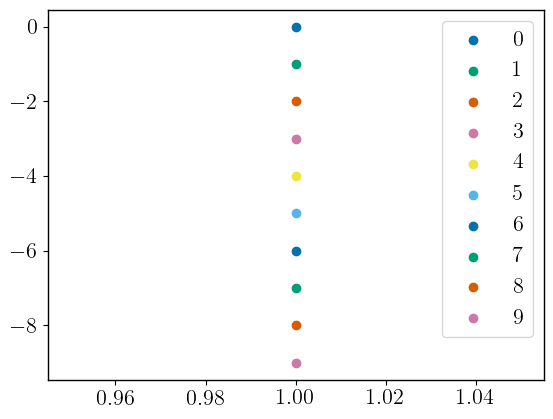

In [47]:
# Plot 10 random lines to test the colors
# Set also the colors to be visually pleasing and colorblind friendly
plt.style.use('seaborn-v0_8-colorblind')
plt.rcParams["image.cmap"] = "viridis"

for i in range(10):
    plt.scatter(1, -i, label=i)
plt.legend()
plt.show()

In [5]:
# Make a function to save the figures
# I want to save the figures in a folder called figures
# The prefix of the figure filename needs to be the same as the notebook filename
# The figures folder is located in PROJECT_DIR/notbooks/figures

# Path: Results.ipynb
import os
import matplotlib.pyplot as plt
import optosim
from optosim.settings import PROJECT_DIR

def save_figure(fig, filename, notebook_name=notebook_name):
    """Save a matplotlib figure in the figures folder of the project.
    The prefix of the figure filename needs to be the same as the notebook filename
    The figures folder is located in PROJECT_DIR/notbooks/figures

    Args:
        fig (matplotlib.figure.Figure): Matplotlib figure to save
        filename (str): Filename of the notebook
        prefix (str, optional): Prefix of the figure filename. Defaults to None.
        folder (str, optional): Folder to save the figure in. Defaults to "figures".
    """

    prefix = notebook_name.lower()

    folder = "figures"

    # Save one png and one pdf version of the figure
    fig.savefig(os.path.join(PROJECT_DIR, "notebook", folder, f"{prefix}-{filename}.png"), dpi=300, bbox_inches="tight")
    fig.savefig(os.path.join(PROJECT_DIR, "notebook", folder, f"{prefix}-{filename}.pdf"), dpi=300, bbox_inches="tight")

    print(f"Figure saved as {prefix}_{filename}")

### Read the simulation data

In [6]:
show_data(DATA_DIR)

Found 2 subdirectories
Subdirectories:
['mc0006', 'mc0007']


,subdir,detector,nevents,nphoton_per_event,set_no_scatter,set_experimental_scatter_model,radius
0,mc0006,XAMS,10000,"[1000, 25000]",False,True,3.2
1,mc0007,XENONnT,10000,"[1000, 25000]",False,True,65.0


In [7]:
run_id = 'mc0007'
nmax = 1_000

# read data
run_id_dir = os.path.join(DATA_DIR, run_id)
files = glob.glob(run_id_dir + '/*.hd5f')

print(f"Reading data from {run_id_dir}")
print(f"Found {len(files)} files")

true_pos, fine_top, top = read_events(files, nmax=nmax)
    

Reading data from /data/xenon/optosim/data/mc0007
Found 99 files
number of files:  99
Found 2 subdirectories
Subdirectories:
['mc0006', 'mc0007']
processed  0 events
processed  1000 events
We have 1000 events
low res PMT has shape (20, 20)
high res truth has shape (100, 100)
true positions have shape (3,)


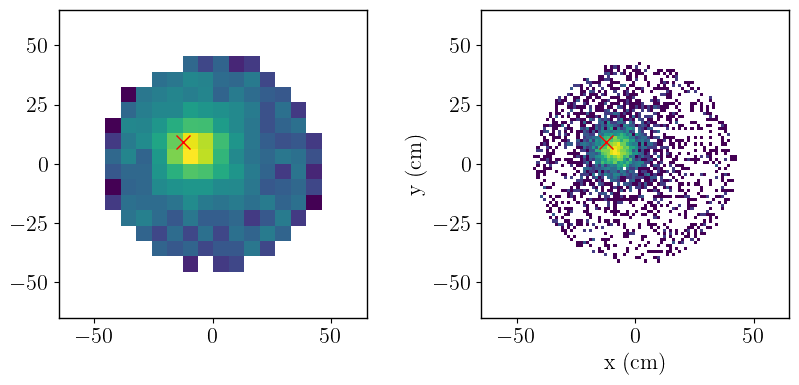

In [34]:
# check if data is ok
num = 4
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax = ax.ravel()
r = 65

ax[0].imshow(
    top[num], 
    interpolation="nearest", 
    origin="lower", 
    extent=[-r, r, -r, r],
    norm=mpl.colors.LogNorm(),
)

ax[1].imshow(
    fine_top[num],
    interpolation="nearest",
    origin="lower",
    extent=[-r, r, -r, r],
    norm=mpl.colors.LogNorm(),

)

for i in range(2):
    ax[i].plot(
        true_pos[num][0],
        true_pos[num][1],
        marker="x",
        markersize=10,
        color="red",
        label="true position",
    )

plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.show()

### Make test data

In [9]:
# create train and test sets
y = np.asarray(fine_top)
X = np.asarray(top)
pos = [pos[:2] for pos in true_pos] # depth is not used

X_train, y_train, pos_train, X_test, y_test, pos_test = create_datasets(X, y, pos, train_fraction=0.8)


In [28]:
# Weighted average estimator

wa_pred = weighted_average_estimator(X_test, r=2.5)
wa_mse = mse(pos_test, wa_pred)
wa_r2 = r_squared(pos_test, wa_pred)

### Get the models

In [11]:
!ls $MODEL_DIR

model_100x100_mc0007.pkl  model_20x20_mc0007.pkl  model_60x60_mc0007.pkl
model_10x10_mc0006.pkl	  model_25x25_mc0007.pkl  model_65x65_mc0007.pkl
model_11x11_mc0006.pkl	  model_2x2_mc0006.pkl	  model_6x6_mc0006.pkl
model_12x12_mc0006.pkl	  model_30x30_mc0007.pkl  model_70x70_mc0007.pkl
model_13x13_mc0006.pkl	  model_35x35_mc0007.pkl  model_75x75_mc0007.pkl
model_14x14_mc0006.pkl	  model_3x3_mc0006.pkl	  model_7x7_mc0006.pkl
model_15x15_mc0006.pkl	  model_40x40_mc0007.pkl  model_80x80_mc0007.pkl
model_16x16_mc0006.pkl	  model_45x45_mc0007.pkl  model_85x85_mc0007.pkl
model_17x17_mc0006.pkl	  model_4x4_mc0006.pkl	  model_8x8_mc0006.pkl
model_18x18_mc0006.pkl	  model_50x50_mc0007.pkl  model_90x90_mc0007.pkl
model_19x19_mc0006.pkl	  model_55x55_mc0007.pkl  model_95x95_mc0007.pkl
model_20x20_mc0006.pkl	  model_5x5_mc0006.pkl	  model_9x9_mc0006.pkl


In [12]:
# Utils

# Let's make a function to read the models from the pickle files
def read_model(model_name):

    print(f"Reading model {model_name}")
    model_file = os.path.join(MODEL_DIR, model_name)
    with open(model_file, 'rb') as f:
        model = pickle.load(f)

    return model


# Define a function to get the number of pmts from a filename like model_2x2_mc0006.pkl
def get_pmts_from_filename(filename):
    return int(filename.split("_")[1].split('x')[0])

# Define a function to get the run id from a filename like model_2x2_mc0006.pkl
def get_filename_from_pmts(pmts_per_dim, run_id):
    return f"model_{pmts_per_dim}x{pmts_per_dim}_{run_id}.pkl"


In [13]:


# Define list of models to read
read_all_models = True

if read_all_models:
    # Let's read all the files, nicely sorted, 
    # only the filename without the path,
    # Sort in a way that 2 comes before 10
    models_to_read = [os.path.basename(x) for x in glob.glob(os.path.join(MODEL_DIR, f"**{run_id}.pkl"))]
    models_to_read = sorted(models_to_read, key=lambda x: int(get_pmts_from_filename(x)))
else: 
    # Read only these files
    pmts_per_dim_to_load = [2,3,4,5,6,7,8,9,10,11,12]
    models_to_read = [get_filename_from_pmts(pmts_per_dim, run_id) for pmts_per_dim in pmts_per_dim_to_load]


# Let's read all the files
models = {}
for model_name in models_to_read:
    models[model_name] = read_model(model_name)

# Let's make a function to predict the position of the events


Reading model model_20x20_mc0007.pkl
Reading model model_25x25_mc0007.pkl
Reading model model_30x30_mc0007.pkl
Reading model model_35x35_mc0007.pkl
Reading model model_40x40_mc0007.pkl
Reading model model_45x45_mc0007.pkl
Reading model model_50x50_mc0007.pkl
Reading model model_55x55_mc0007.pkl
Reading model model_60x60_mc0007.pkl
Reading model model_65x65_mc0007.pkl
Reading model model_70x70_mc0007.pkl
Reading model model_75x75_mc0007.pkl
Reading model model_80x80_mc0007.pkl
Reading model model_85x85_mc0007.pkl
Reading model model_90x90_mc0007.pkl
Reading model model_95x95_mc0007.pkl
Reading model model_100x100_mc0007.pkl


In [14]:
# Make a result dictionary with the results for each model

results = {}

for model_name, model in models.items():
    print(f"Predicting with model {model_name}")

    _pmts = get_pmts_from_filename(model_name)
    res = model.evaluate(X_test, downsample_heatmaps_to_dimensions(y_test, _pmts, _pmts), pos_test)

    results[model_name] = {}
    results[model_name]['PMTs'] = _pmts
    results[model_name]['pred'] = model.predict(X_test)[1]
    results[model_name]['MSE'] = res['MSE']
    results[model_name]['R^2'] = res['R^2']

Predicting with model model_20x20_mc0007.pkl


Predicting with model model_25x25_mc0007.pkl
Predicting with model model_30x30_mc0007.pkl
Predicting with model model_35x35_mc0007.pkl
Predicting with model model_40x40_mc0007.pkl
Predicting with model model_45x45_mc0007.pkl
Predicting with model model_50x50_mc0007.pkl
Predicting with model model_55x55_mc0007.pkl
Predicting with model model_60x60_mc0007.pkl
Predicting with model model_65x65_mc0007.pkl
Predicting with model model_70x70_mc0007.pkl
Predicting with model model_75x75_mc0007.pkl
Predicting with model model_80x80_mc0007.pkl
Predicting with model model_85x85_mc0007.pkl
Predicting with model model_90x90_mc0007.pkl
Predicting with model model_95x95_mc0007.pkl
Predicting with model model_100x100_mc0007.pkl


model: model_20x20_mc0007.pkl        


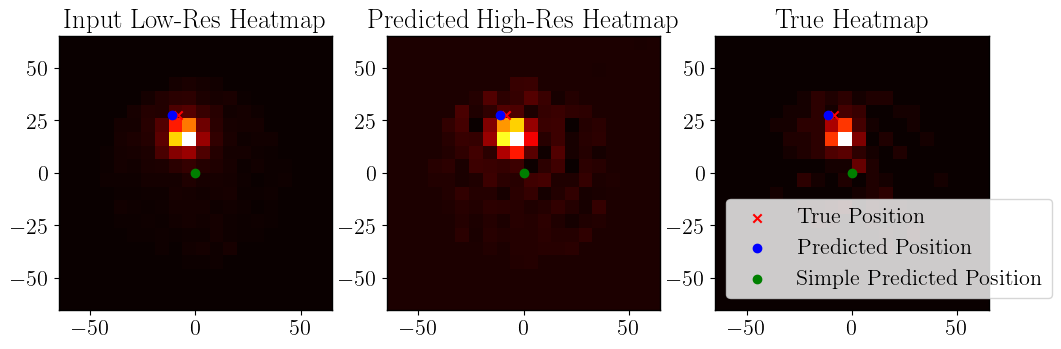

model: model_25x25_mc0007.pkl        


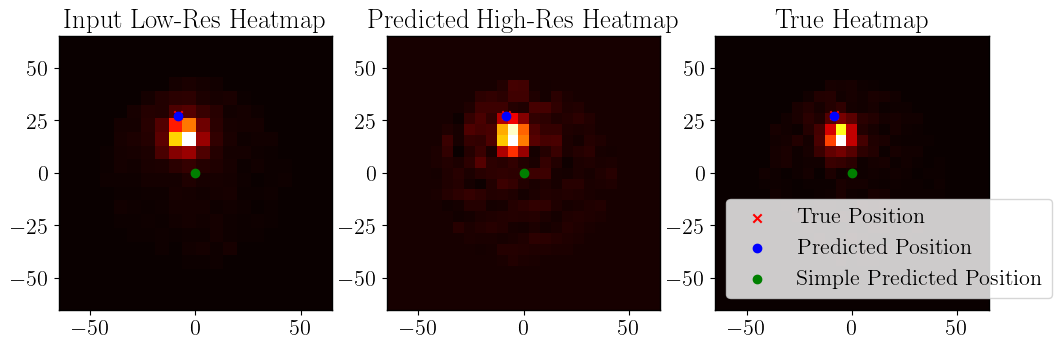

model: model_30x30_mc0007.pkl        


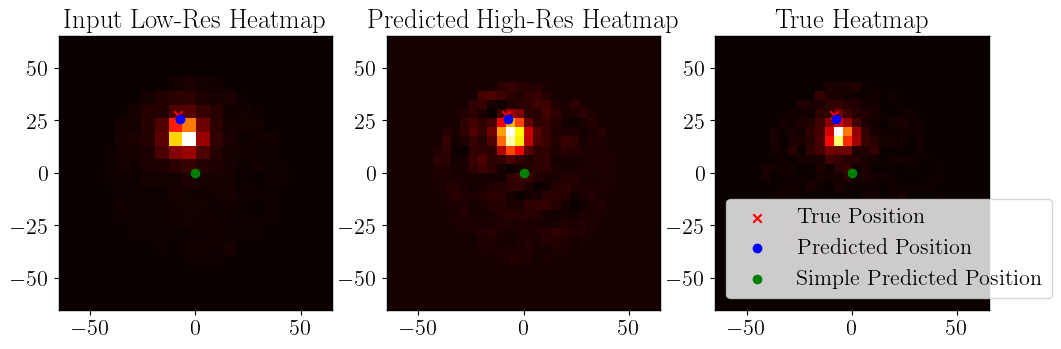

model: model_35x35_mc0007.pkl        


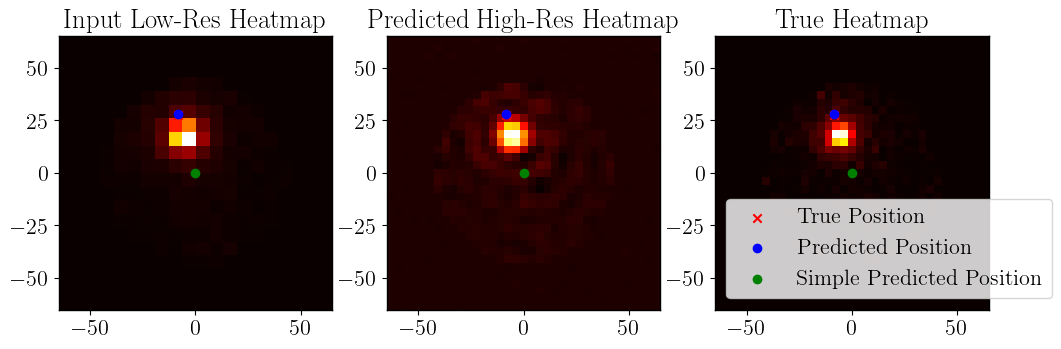

model: model_40x40_mc0007.pkl        


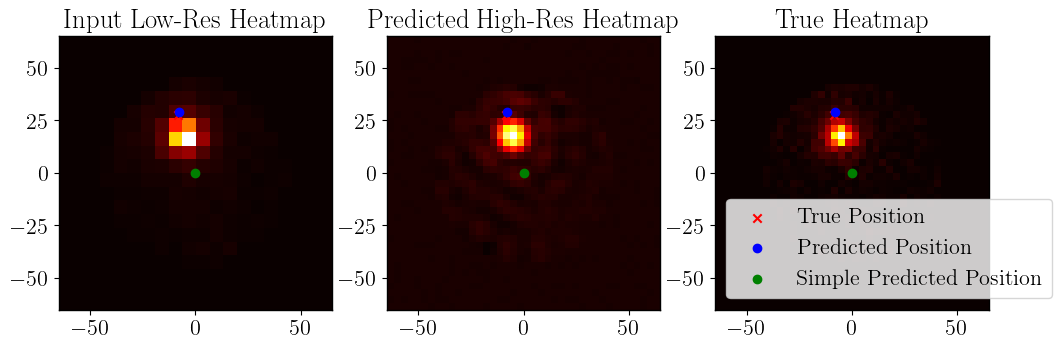

model: model_45x45_mc0007.pkl        


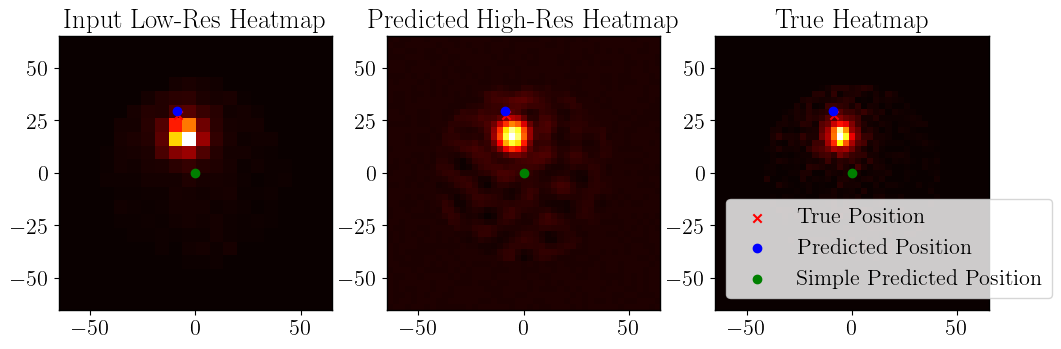

model: model_50x50_mc0007.pkl        


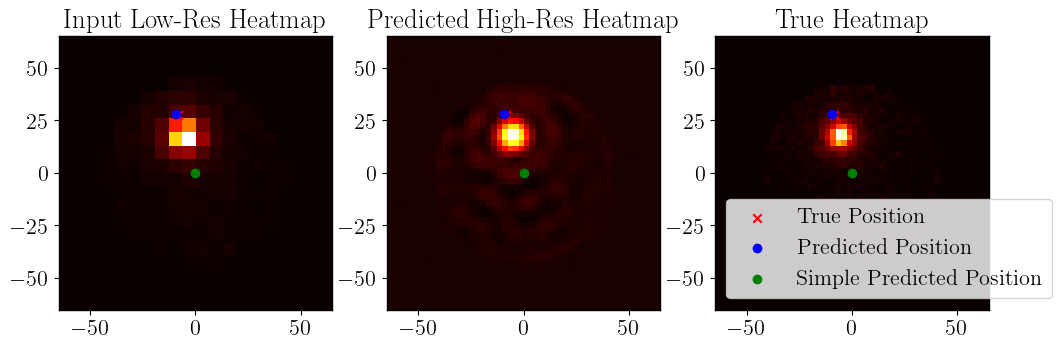

model: model_55x55_mc0007.pkl        


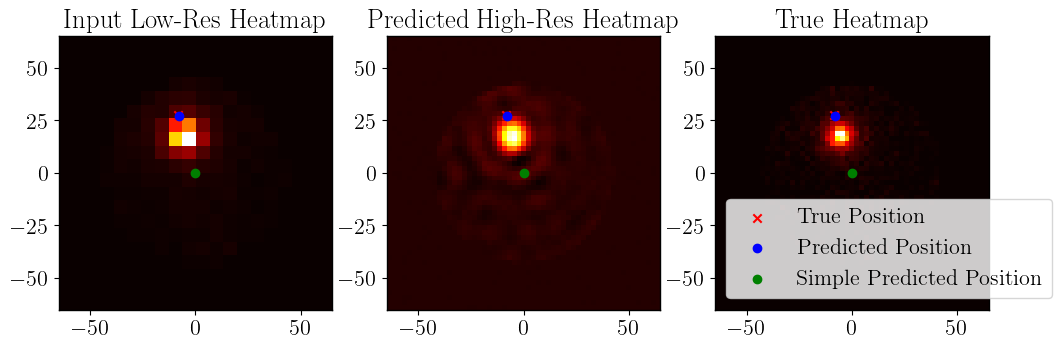

model: model_60x60_mc0007.pkl        


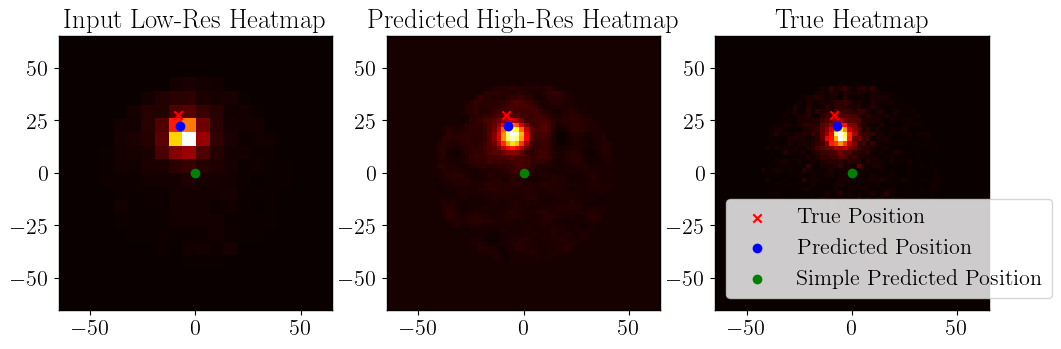

model: model_65x65_mc0007.pkl        


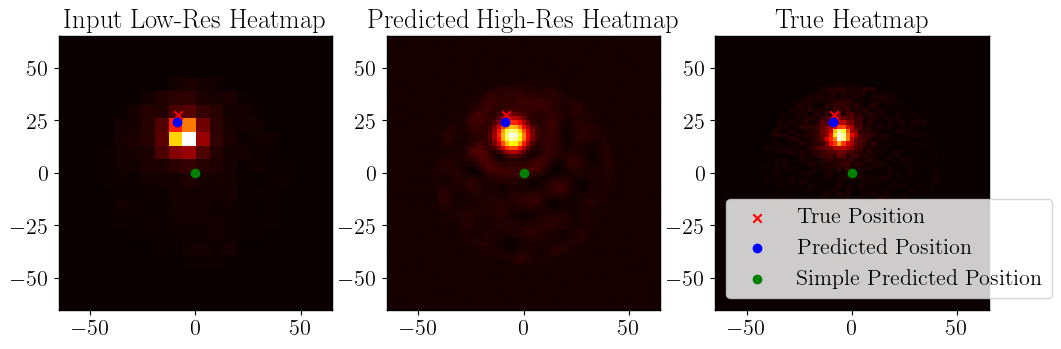

model: model_70x70_mc0007.pkl        


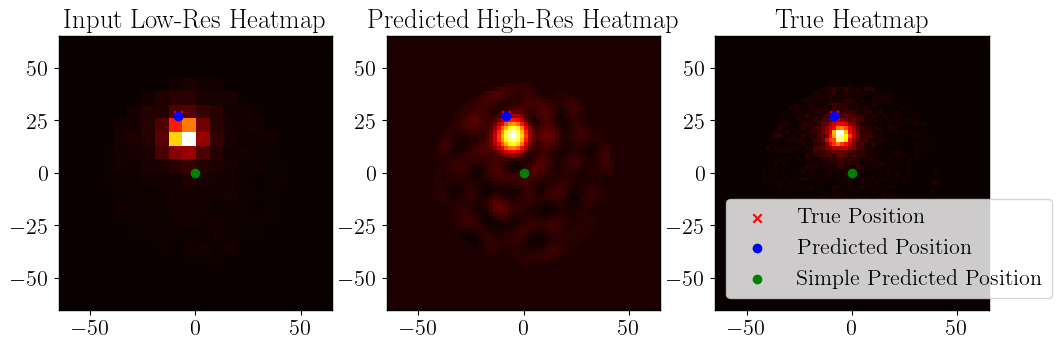

model: model_75x75_mc0007.pkl        


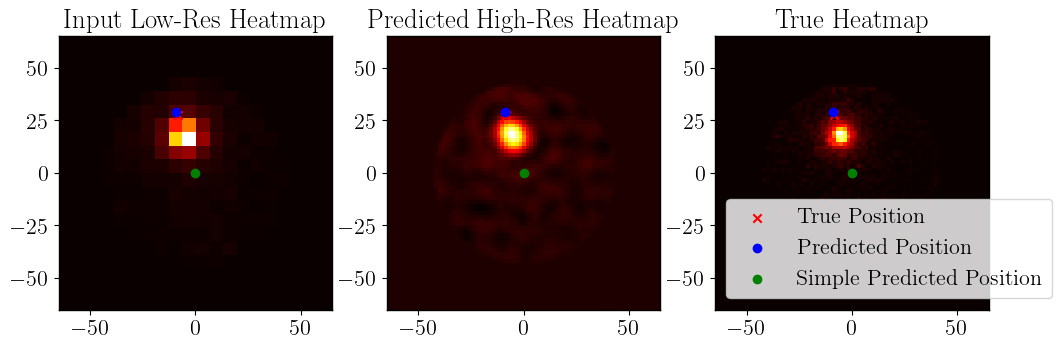

model: model_80x80_mc0007.pkl        


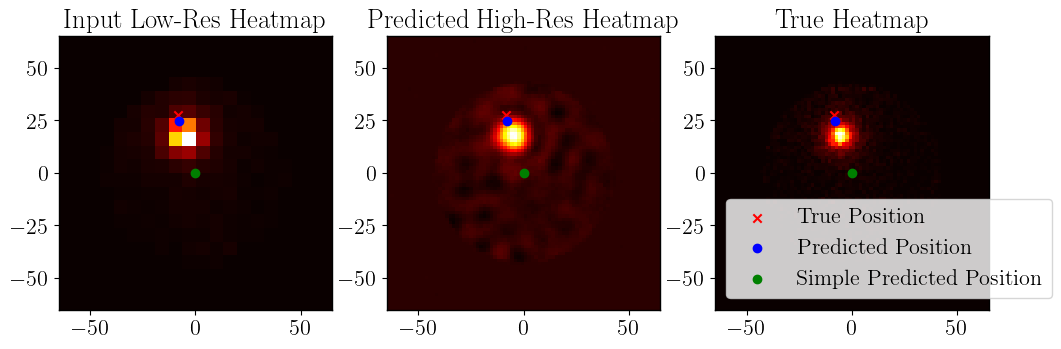

model: model_85x85_mc0007.pkl        


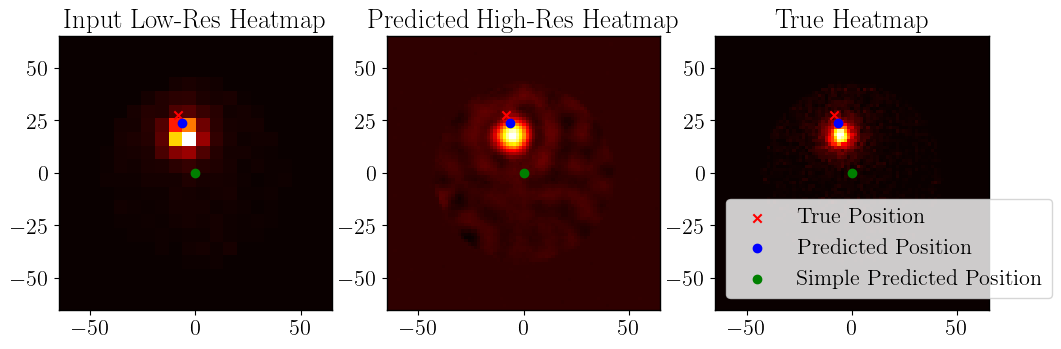

model: model_90x90_mc0007.pkl        


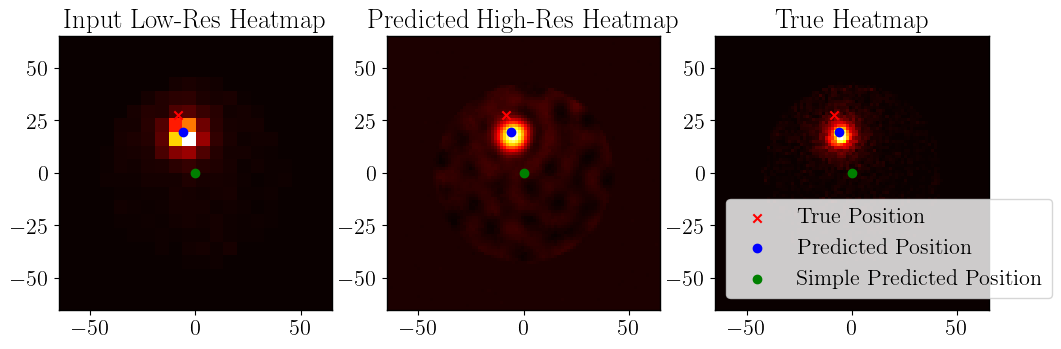

model: model_95x95_mc0007.pkl        


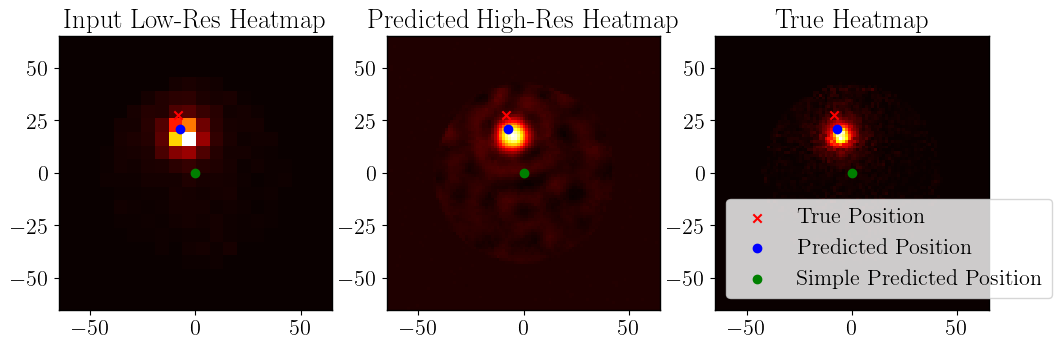

model: model_100x100_mc0007.pkl      


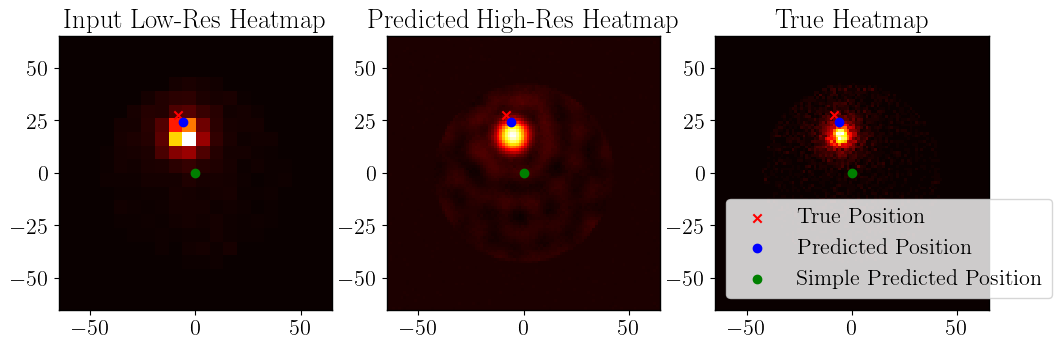

In [15]:
for model_name, model in models.items():

    _pmts = get_pmts_from_filename(model_name)

    print(f"model: {model_name:<30}")

    y_test_downsampled = downsample_heatmaps_to_dimensions(y_test, _pmts, _pmts)

    model.visualize_heatmaps_with_positions(X_test, y_test_downsampled, pos_test, num_plots=1, radius=65)

## Let's make nice plots

- 2d histogram of true x - x vs true y - y :: resolution of best model\\
- 1d histogram of true r - r :: resolution of best model\\
- comparison of resolutions (MSE/R2) for different models\\
- error correlation with position\\

We decide that the best model is 5x5

In [16]:
radius = 65

model: model_20x20_mc0007.pkl         --PMTS: 20 -- RSE: 6.9646 -- R^2: 0.9937
model: model_25x25_mc0007.pkl         --PMTS: 25 -- RSE: 2.9582 -- R^2: 0.9973
model: model_30x30_mc0007.pkl         --PMTS: 30 -- RSE: 2.1739 -- R^2: 0.9980
model: model_35x35_mc0007.pkl         --PMTS: 35 -- RSE: 3.6540 -- R^2: 0.9967
model: model_40x40_mc0007.pkl         --PMTS: 40 -- RSE: 3.0724 -- R^2: 0.9972
model: model_45x45_mc0007.pkl         --PMTS: 45 -- RSE: 5.3549 -- R^2: 0.9951
model: model_50x50_mc0007.pkl         --PMTS: 50 -- RSE: 6.4143 -- R^2: 0.9942
model: model_55x55_mc0007.pkl         --PMTS: 55 -- RSE: 6.3422 -- R^2: 0.9942
model: model_60x60_mc0007.pkl         --PMTS: 60 -- RSE: 10.4581 -- R^2: 0.9905
model: model_65x65_mc0007.pkl         --PMTS: 65 -- RSE: 9.1931 -- R^2: 0.9916
model: model_70x70_mc0007.pkl         --PMTS: 70 -- RSE: 18.6185 -- R^2: 0.9830
model: model_75x75_mc0007.pkl         --PMTS: 75 -- RSE: 20.5819 -- R^2: 0.9812
model: model_80x80_mc0007.pkl         --PMTS: 80 

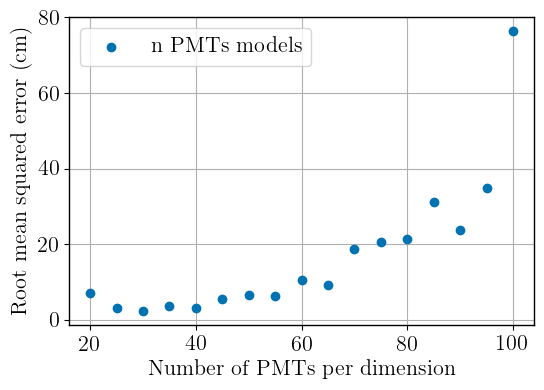

In [29]:
# Do scatter plot with mse only

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, MultipleLocator


# Get the first color of the color cycle from the style
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]

for i, model_name in enumerate(models.keys()):

    res = results[model_name]

    # Print for each key of the res dict the key and the value (with 4 digits after the comma), in the same line
    print(f"model: {model_name:<30} --PMTS: {res['PMTs']} -- RSE: {res['MSE']:.4f} -- R^2: {res['R^2']:.4f}")

    if i == 0:
        ax.scatter(res['PMTs'], res['MSE'], label='n PMTs models', color=color)
    else:
        ax.scatter(res['PMTs'], res['MSE'], c=color)


color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]

ax.set_ylabel("Root mean squared error (cm)")
ax.set_xlabel("Number of PMTs per dimension")

# Show this plot first, and then again but with log scale

# plt.yscale('log')

# I want the grid to be under the points
ax.set_axisbelow(True)
ax.grid(True)
ax.grid(which='minor', alpha=0.2)

# # Set y-axis ticks to be non-scientific notation
# yaxis = ax.yaxis
# yaxis.set_major_formatter(ScalarFormatter())
# # yaxis.set_minor_formatter(ScalarFormatter())

# # Set y-axis tick frequency to 0.01
# yaxis.set_major_locator(MultipleLocator(0.05))
# yaxis.set_minor_locator(MultipleLocator(0.01))


# # Add ticks on x axis for each PMT number upto 5 then every 5
# xaxis = ax.xaxis
# xaxis.set_major_locator(MultipleLocator(5))
# xaxis.set_minor_locator(MultipleLocator(1))

# # Set x-axis ticks to be non-scientific notation
# xaxis.set_major_formatter(ScalarFormatter())



# plt.ylim(0.03, 0.25)

plt.legend()

save_figure(fig, "mse_per_model")
plt.show()



In [18]:
stupid_model_name = 'model_2x2_mc0006.pkl'
stupid_model = models[stupid_model_name]

model_name = 'model_5x5_mc0006.pkl'
model = models[model_name]

finest_model_name = 'model_20x20_mc0006.pkl'
finest_model = models[finest_model_name]

KeyError: 'model_2x2_mc0006.pkl'

In [ ]:
# Best model

_pmts = get_pmts_from_filename(model_name)

print(f"model: {model_name:<30}")

pred_pos = model.predict(X_test)[1]

y_test_downsampled = downsample_heatmaps_to_dimensions(y_test, _pmts, _pmts)

# Stupid model

_stupid_pmts = get_pmts_from_filename(stupid_model_name)

print(f"model: {stupid_model_name:<30}")

stupid_pred_pos = stupid_model.predict(X_test)[1]

stupid_y_test_downsampled = downsample_heatmaps_to_dimensions(y_test, _stupid_pmts, _stupid_pmts)

# Finest model 

_finest_pmts = get_pmts_from_filename(finest_model_name)

print(f"model: {finest_model_name:<30}")

finest_pred_pos = finest_model.predict(X_test)[1]

finest_y_test_downsampled = downsample_heatmaps_to_dimensions(y_test, _finest_pmts, _finest_pmts)

model: model_5x5_mc0006.pkl          
model: model_2x2_mc0006.pkl          
model: model_20x20_mc0006.pkl        


In [ ]:
# How many events do we have in every array

len(X_test), len(y_test), len(pos_test), len(pred_pos)

(2000, 2000, 2000, 2000)

Figure saved as results_dx_dy_best_model


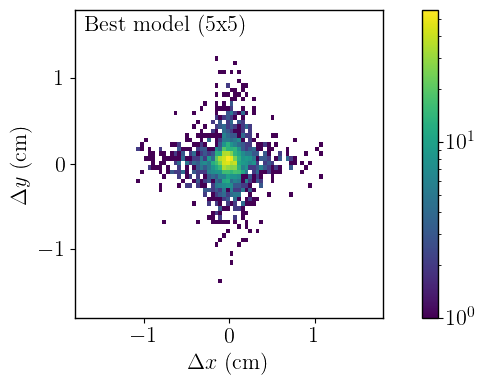

In [ ]:
# Make the 2D histogram of (x-x_pred, y-y_pred)

from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

plt.hist2d(
    pred_pos[:,0] - pos_test[:,0],
    pred_pos[:,1] - pos_test[:,1],
    bins=50,
    norm=LogNorm()
)

# Nice latex labels
plt.xlabel("$\Delta x$ (cm)")
plt.ylabel("$\Delta y$ (cm)")

plt.colorbar()

# Set aspect ratio to 1
ax.set_aspect(1)

# Make it a square
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)

# Add a text with the model name and the number of PMTs in a frame
plt.text(-1.7, 1.55, f"Best model (5x5)", fontsize=16)


save_figure(fig, "dx_dy_best_model")


plt.show()




Figure saved as results_dx_dy_stupid_model


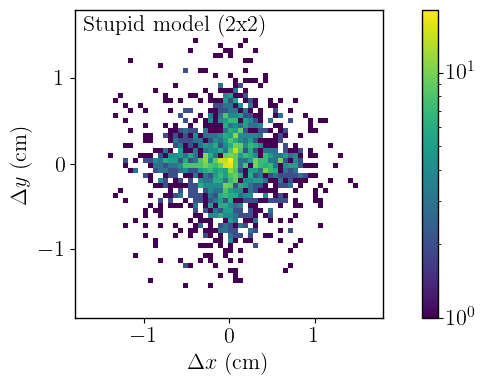

In [ ]:
# Make the 2D histogram of (x-x_pred, y-y_pred)

from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

plt.hist2d(
    stupid_pred_pos[:,0] - pos_test[:,0],
    stupid_pred_pos[:,1] - pos_test[:,1],
    bins=50,
    norm=LogNorm()
)

# Nice latex labels
plt.xlabel("$\Delta x$ (cm)")
plt.ylabel("$\Delta y$ (cm)")

plt.colorbar()

# Set aspect ratio to 1
ax.set_aspect(1)

# Make it a square
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)

# Add a text with the model name and the number of PMTs in a frame
plt.text(-1.7, 1.55, f"Stupid model (2x2)", fontsize=16)


save_figure(fig, "dx_dy_stupid_model")

plt.show()




Figure saved as results_dr_per_model


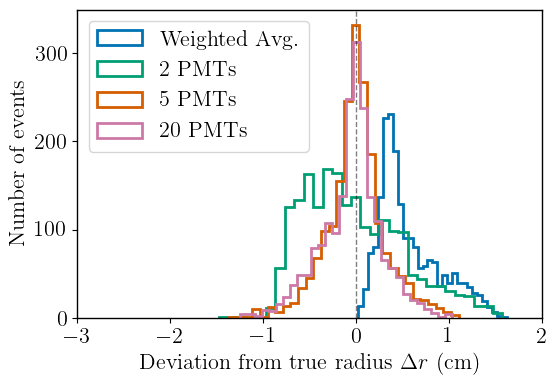

In [ ]:
# Do a plot of delta R versus R, comparing the best model with the stupid model and the weighted average estimator

# Get the radius of the events
r = np.linalg.norm(pos_test, axis=1)

# Get the radius of the predicted events
r_pred = np.linalg.norm(pred_pos, axis=1)

# Get the radius of the predicted events
stupid_r_pred = np.linalg.norm(stupid_pred_pos, axis=1)

# Get the radius of the predicted events
finest_model_r_pred = np.linalg.norm(finest_pred_pos, axis=1)

# Get the delta r
dr = r_pred - r
stupid_dr = stupid_r_pred - r
finest_dr = finest_model_r_pred - r
wa_dr = np.linalg.norm(wa_pred - pos_test, axis=1)

n_bins = 30

# Plot delta r versus r
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

plt.hist(
    wa_dr,
    bins=n_bins,
    label="Weighted Avg.",
    histtype="step",
    linewidth=2,

)

plt.hist(
    stupid_dr,
    bins=n_bins,
    label=f"{_stupid_pmts} PMTs",
    histtype="step",
    linewidth=2,

)


plt.hist(
    dr,
    bins=n_bins,
    label=f"{_pmts} PMTs",
    histtype="step",
    linewidth=2,

)

plt.hist(
    finest_dr,
    bins=n_bins,
    label=f"{_finest_pmts} PMTs",
    histtype="step",
    linewidth=2,

)


plt.axvline(0, color="black", linestyle="--", linewidth=1, alpha=0.5)

plt.xlim(-3,2)

plt.xlabel("Deviation from true radius $\Delta r$ (cm)")
plt.ylabel("Number of events")

plt.legend()

save_figure(fig, "dr_per_model")

plt.show()


In [205]:
n_bins = 30

# Get the average distance per each r bin
r_bins = np.linspace(0, radius, n_bins)
r_bin_centers = (r_bins[1:] + r_bins[:-1]) / 2

Figure saved as results_dr_vs_r_per_model


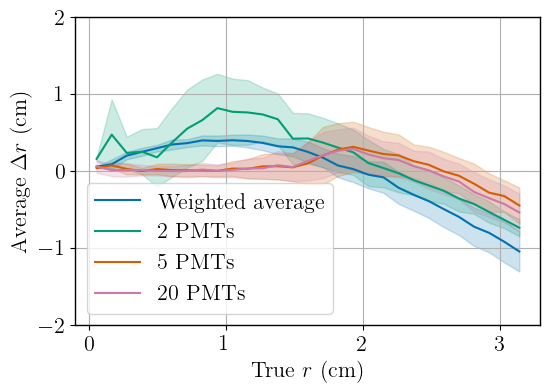

In [206]:
# Now the average distance versus r for the three models

# Get the radius of the events
r = np.linalg.norm(pos_test, axis=1)


# Get the distance between the predicted and true positions
dr = np.linalg.norm(pred_pos, axis=1) - r
stupid_dr = np.linalg.norm(stupid_pred_pos, axis=1) - r
wa_dr = np.linalg.norm(wa_pred, axis=1) - r
finest_dr = np.linalg.norm(finest_pred_pos, axis=1) - r


dr_mean, _, _ = stats.binned_statistic(r, dr, statistic='mean', bins=r_bins)
dr_std, _, _ = stats.binned_statistic(r, dr, statistic='std', bins=r_bins)

stupid_dr_mean, _, _ = stats.binned_statistic(r, stupid_dr, statistic='mean', bins=r_bins)
stupid_dr_std, _, _ = stats.binned_statistic(r, stupid_dr, statistic='std', bins=r_bins)

wa_dr_mean, _, _ = stats.binned_statistic(r, wa_dr, statistic='mean', bins=r_bins)
wa_dr_std, _, _ = stats.binned_statistic(r, wa_dr, statistic='std', bins=r_bins)

finest_dr_mean, _, _ = stats.binned_statistic(r, finest_dr, statistic='mean', bins=r_bins)
finest_dr_std, _, _ = stats.binned_statistic(r, finest_dr, statistic='std', bins=r_bins)


# Plot residuals versus r
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Get first color of the color cycle
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]

# Plot the mean residuals as a line
plt.plot(
    r_bin_centers,
    wa_dr_mean,
    markersize=5,
    color=color,
    label="Weighted average",

)

# Add shaded region for the standard deviation
plt.fill_between(
    r_bin_centers,
    wa_dr_mean - wa_dr_std,
    wa_dr_mean + wa_dr_std,
    alpha=0.2,
    color=color,
)

# # Add error bars for the mean residuals
# plt.errorbar(
#     r_bin_centers,
#     wa_dr_mean,
#     yerr=wa_dr_std,
#     label="Weighted average",
#     fmt='o',
#     markersize=5,
#     capsize=3,
#     color=color,
#     alpha=0.5,
# )

# Get second color of the color cycle
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]

# Plot the mean residuals as a line
plt.plot(
    r_bin_centers,
    stupid_dr_mean,
    markersize=5,
    color=color,
    label=f"{_stupid_pmts} PMTs",

)

# Add shaded region for the standard deviation
plt.fill_between(
    r_bin_centers,
    stupid_dr_mean - stupid_dr_std,
    stupid_dr_mean + stupid_dr_std,
    alpha=0.2,
    color=color,
)

# # Add error bars for the mean residuals
# plt.errorbar(
#     r_bin_centers,
#     stupid_dr_mean,
#     yerr=stupid_dr_std,
#     label=f"{_stupid_pmts} PMTs",
#     fmt='o',
#     markersize=5,
#     capsize=3,
#     color=color,
#     alpha=0.5,
# )

# Get third color of the color cycle
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]

# Plot the mean residuals as a line
plt.plot(
    r_bin_centers,
    dr_mean,
    markersize=5,
    color=color,
    label=f"{_pmts} PMTs",

)

# Add shaded region for the standard deviation
plt.fill_between(
    r_bin_centers,
    dr_mean - dr_std,
    dr_mean + dr_std,
    alpha=0.2,
    color=color,
)

# # Add error bars for the mean residuals
# plt.errorbar(
#     r_bin_centers,
#     dr_mean,
#     yerr=dr_std,
#     label=f"{_pmts} PMTs",
#     fmt='o',
#     markersize=5,
#     capsize=3,
#     color=color,
#     alpha=0.5,
# )


color = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]

# Plot the mean residuals as a line

plt.plot(
    r_bin_centers,
    finest_dr_mean,
    markersize=5,
    color=color,
    label=f"{_finest_pmts} PMTs",

)

# Add shaded region for the standard deviation
plt.fill_between(
    r_bin_centers,
    finest_dr_mean - finest_dr_std,
    finest_dr_mean + finest_dr_std,
    alpha=0.2,
    color=color,
)

plt.xlabel("True $r$ (cm)")
plt.ylabel("Average $\Delta r$ (cm)")

plt.legend()

plt.ylim(-2, 2)

# Add grid
plt.grid(True)

save_figure(fig, "dr_vs_r_per_model")

plt.show()

Figure saved as results_dist_vs_r_per_model


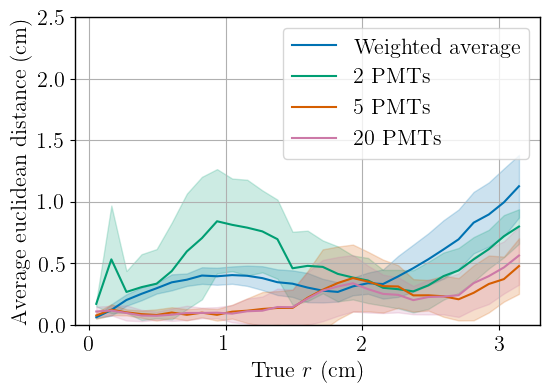

In [209]:
# Plot distance versus r
fig, ax = plt.subplots(1, 1, figsize=(6, 4))


# Get the distance between the predicted and true positions
dist = np.linalg.norm(pred_pos - pos_test, axis=1)

# Get the distance between the predicted and true positions for the stupid model
stupid_model_dist = np.linalg.norm(stupid_pred_pos - pos_test, axis=1)

# Get the distance between the predicted and true positions for the weighted average model
wa_dist = np.linalg.norm(wa_pred - pos_test, axis=1)

# Get the distance between the predicted and true positions for the finest model
finest_model_dist = np.linalg.norm(finest_pred_pos - pos_test, axis=1)

dist_mean, _, _ = stats.binned_statistic(r, dist, statistic='mean', bins=r_bins)
dist_std, _, _ = stats.binned_statistic(r, dist, statistic='std', bins=r_bins)

stupid_model_dist_mean, _, _ = stats.binned_statistic(r, stupid_model_dist, statistic='mean', bins=r_bins)
stupid_model_dist_std, _, _ = stats.binned_statistic(r, stupid_model_dist, statistic='std', bins=r_bins)

wa_dist_mean, _, _ = stats.binned_statistic(r, wa_dist, statistic='mean', bins=r_bins)
wa_dist_std, _, _ = stats.binned_statistic(r, wa_dist, statistic='std', bins=r_bins)

finest_model_dist_mean, _, _ = stats.binned_statistic(r, finest_model_dist, statistic='mean', bins=r_bins)
finest_model_dist_std, _, _ = stats.binned_statistic(r, finest_model_dist, statistic='std', bins=r_bins)


# Get first color of the color cycle
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]

# Plot the mean distance as a line
plt.plot(
    r_bin_centers,
    wa_dist_mean,
    markersize=5,
    color=color,
    label="Weighted average",

)

# Add shaded region for the standard deviation
plt.fill_between(
    r_bin_centers,
    wa_dist_mean - wa_dist_std,
    wa_dist_mean + wa_dist_std,
    alpha=0.2,
    color=color,
)

# # Add error bars for the mean distance
# plt.errorbar(
#     r_bin_centers,
#     wa_dist_mean,
#     yerr=wa_dist_std,
#     fmt='o',
#     markersize=5,
#     capsize=3,
#     color=color,
#     alpha=0.5,
# )

# Get second color of the color cycle
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]

# Plot the mean distance as a line
plt.plot(
    r_bin_centers,
    stupid_model_dist_mean,
    markersize=5,
    color=color,
    label=f"{_stupid_pmts} PMTs",
)

# Add shaded region for the standard deviation
plt.fill_between(
    r_bin_centers,
    stupid_model_dist_mean - stupid_model_dist_std,
    stupid_model_dist_mean + stupid_model_dist_std,
    alpha=0.2,
    color=color,

)

# # Add error bars for the mean distance
# plt.errorbar(
#     r_bin_centers,
#     stupid_model_dist_mean,
#     yerr=stupid_model_dist_std,
#     label=f"{_stupid_pmts} PMTs",
#     fmt='o',
#     markersize=5,
#     capsize=3,
#     color=color,
#     alpha=0.5,
# )

# Get third color of the color cycle
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]

# Plot the mean distance as a line
plt.plot(
    r_bin_centers,
    dist_mean,
    markersize=5,
    color=color,
    label=f"{_pmts} PMTs",
)

# Add shaded region for the standard deviation
plt.fill_between(
    r_bin_centers,
    dist_mean - dist_std,
    dist_mean + dist_std,
    alpha=0.2,
    color=color,
)

# # Add error bars for the mean distance
# plt.errorbar(
#     r_bin_centers,
#     dist_mean,
#     yerr=dist_std,
#     label=f"{_pmts} PMTs",
#     fmt='o',
#     markersize=5,
#     capsize=3,
#     color=color,
#     alpha=0.5,
# )

color = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]

# Plot the mean distance as a line
plt.plot(
    r_bin_centers,
    finest_model_dist_mean,
    markersize=5,
    color=color,
    label=f"{_finest_pmts} PMTs",
)

# Add shaded region for the standard deviation
plt.fill_between(
    r_bin_centers,
    finest_model_dist_mean - finest_model_dist_std,
    finest_model_dist_mean + finest_model_dist_std,
    alpha=0.2,
    color=color,
)


plt.xlabel("True $r$ (cm)")
plt.ylabel("Average euclidean distance (cm)")

plt.legend()

plt.ylim(0, 2.5)

# Add grid
plt.grid(True)

save_figure(fig, "dist_vs_r_per_model")

plt.show()